In [2]:
from typing import Callable

from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, Dataset
import torch

from utils.load_data import *
import numpy as np
from scipy import signal

BCIC_dataset = load_BCIC(
train_sub=[1,2,3,4,5,6,7,8],
test_sub=[9],
alg_name = 'Tensor_CSPNet',
scenario = 'raw-signal-si'
)

train_x, train_y, test_x, test_y = BCIC_dataset.generate_training_valid_test_set_subject_independent()



/home/junyeobe/.local/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
2023-04-26 18:28:58.117249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 18:28:58.666854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


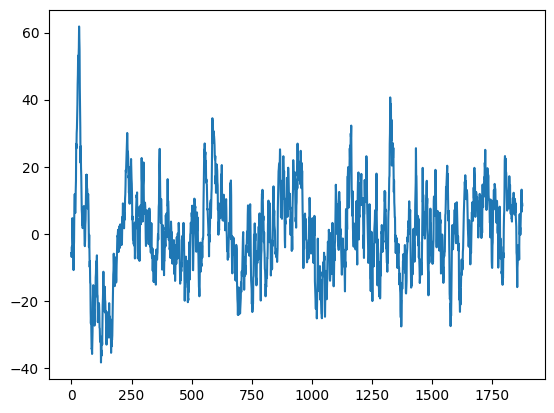

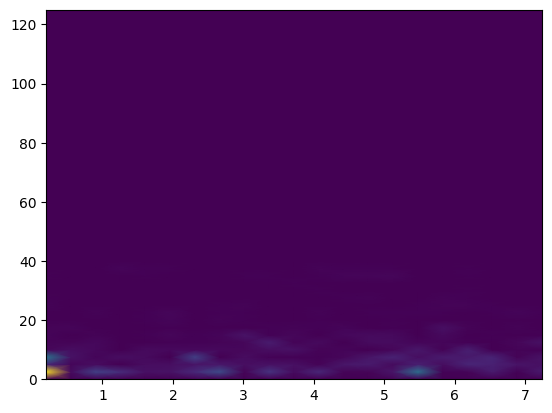

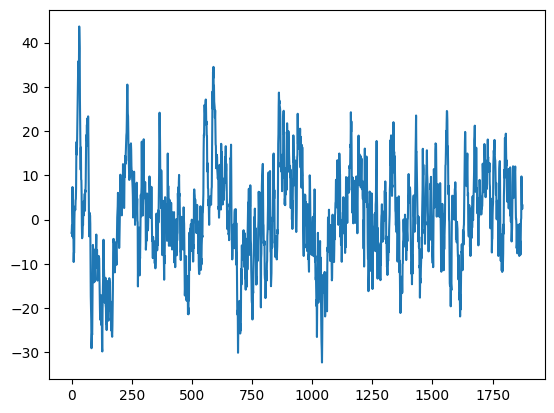

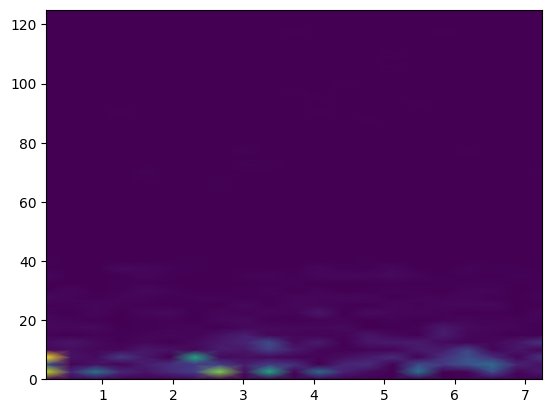

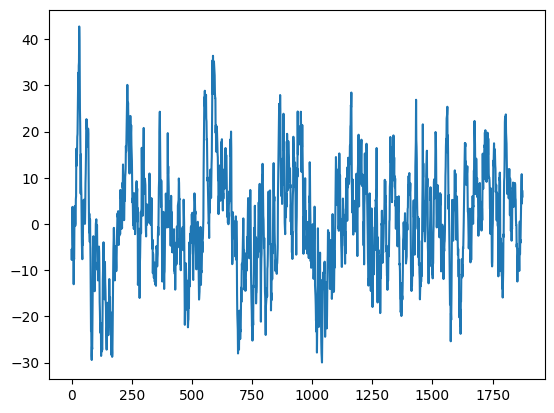

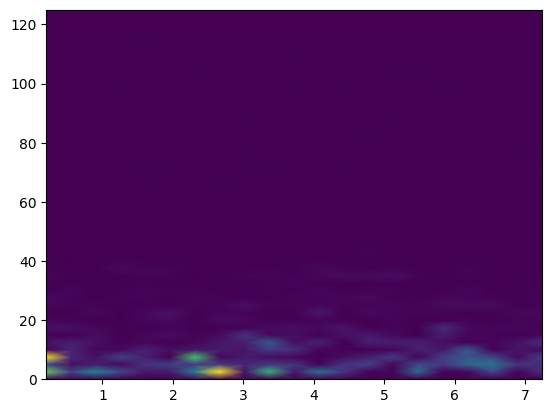

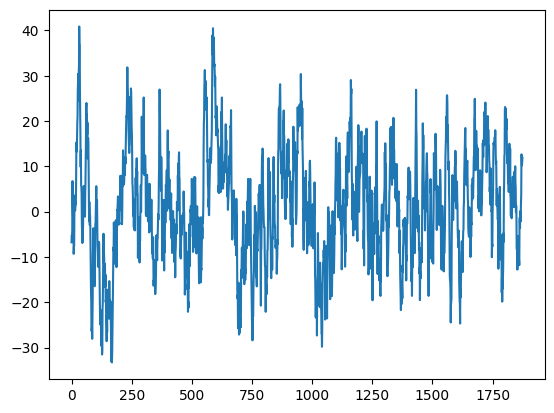

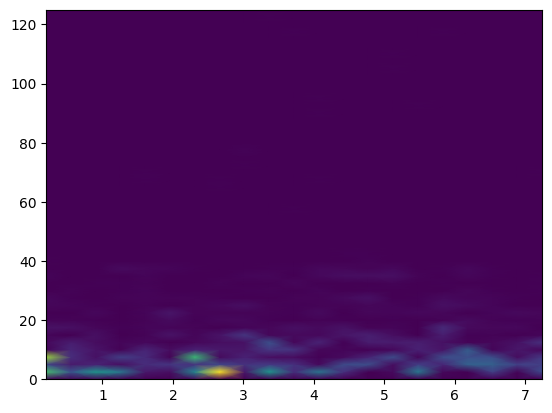

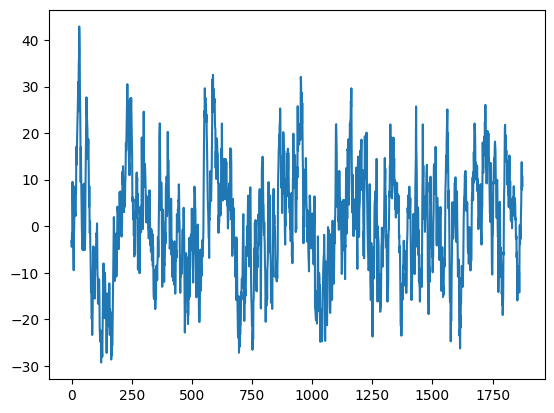

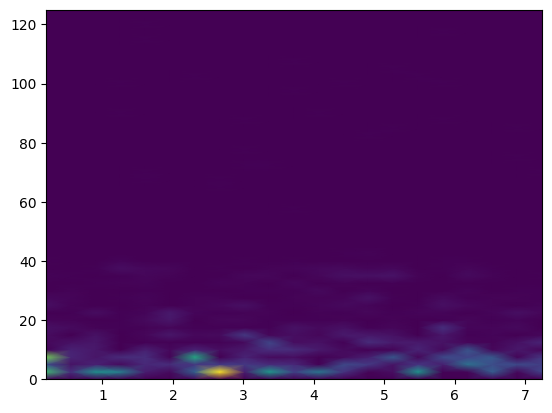

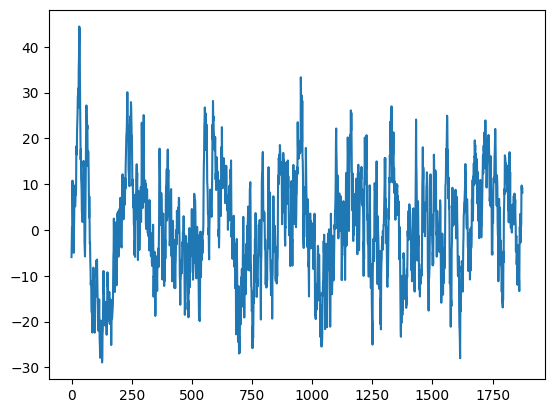

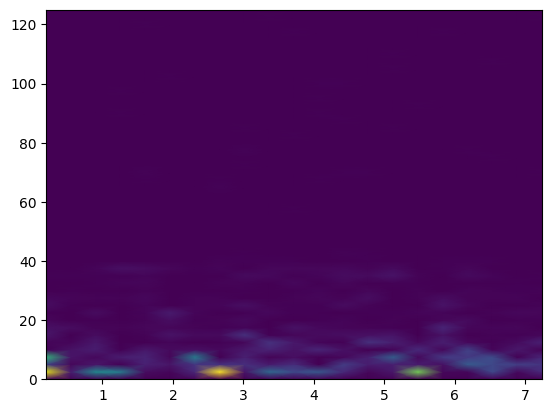

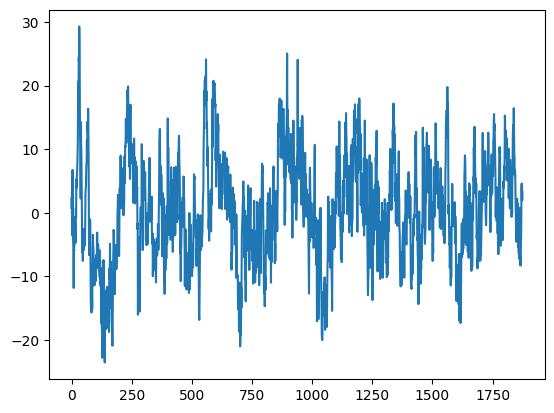

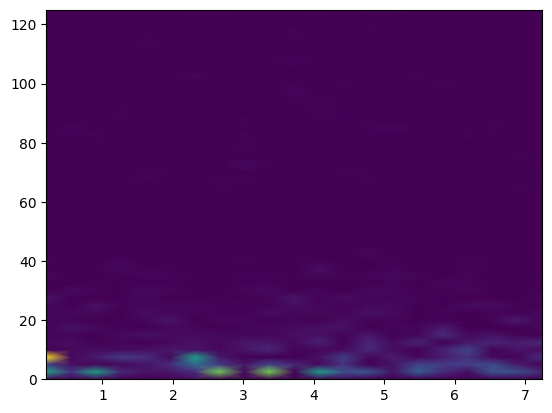

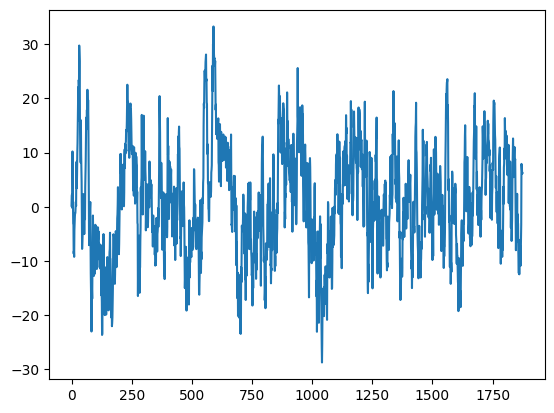

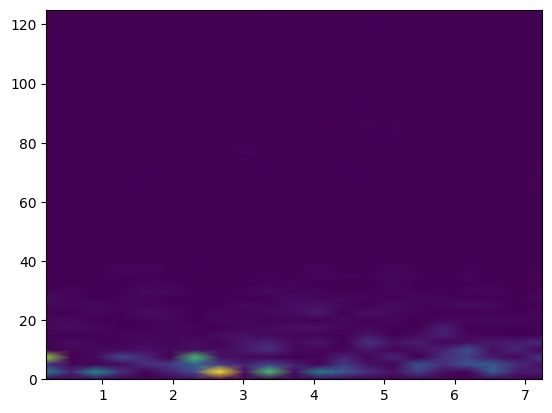

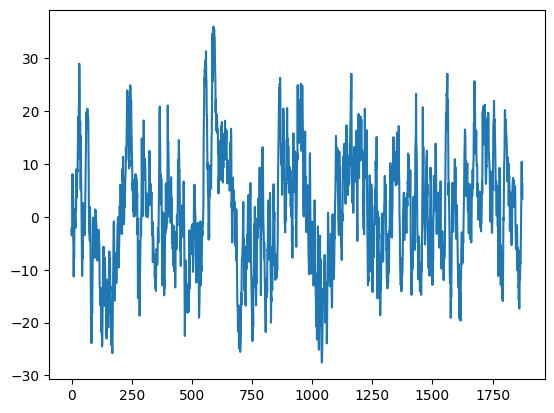

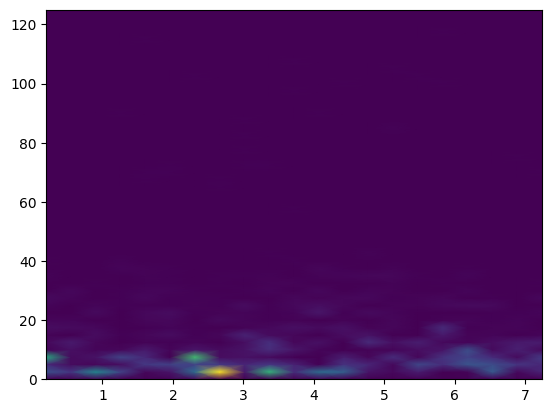

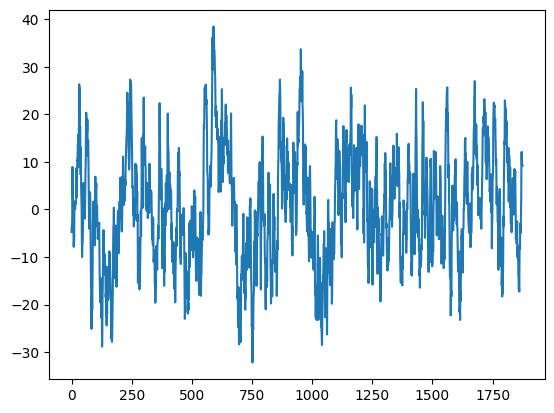

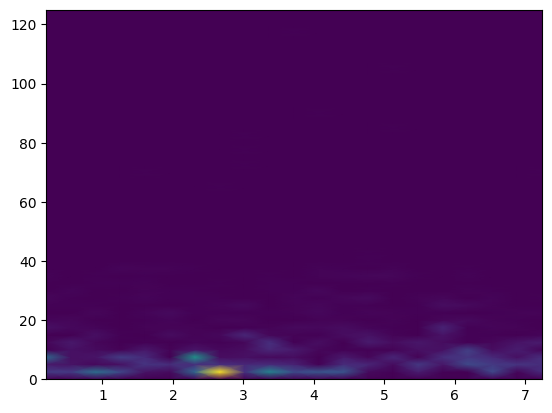

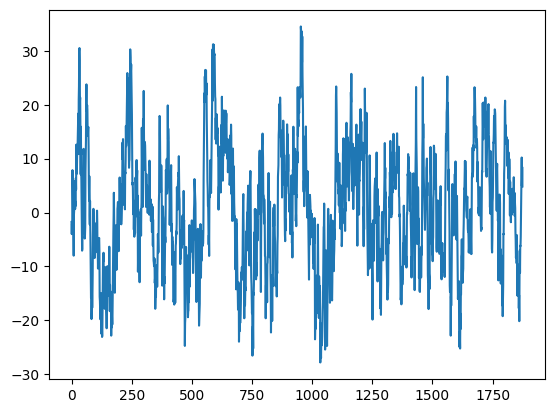

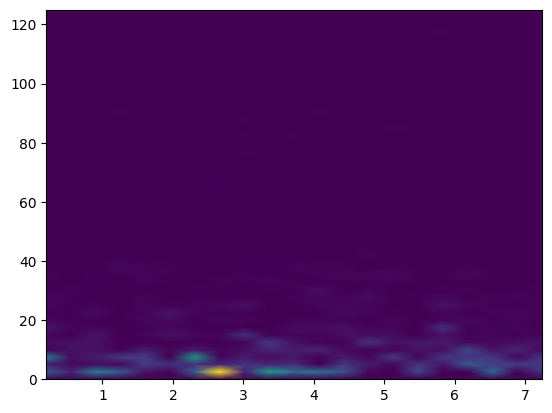

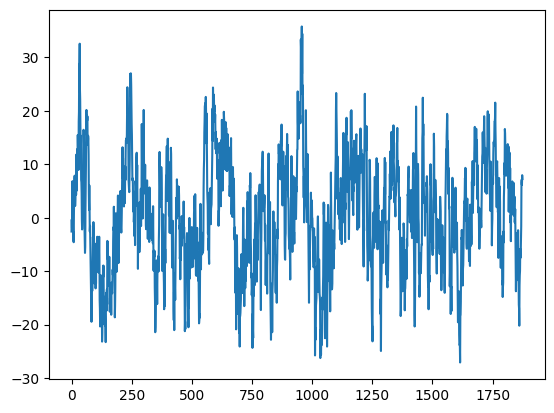

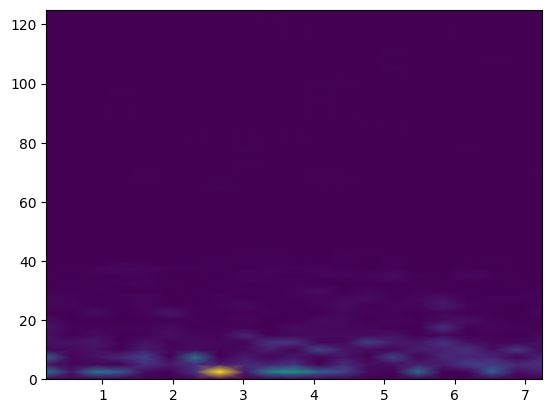

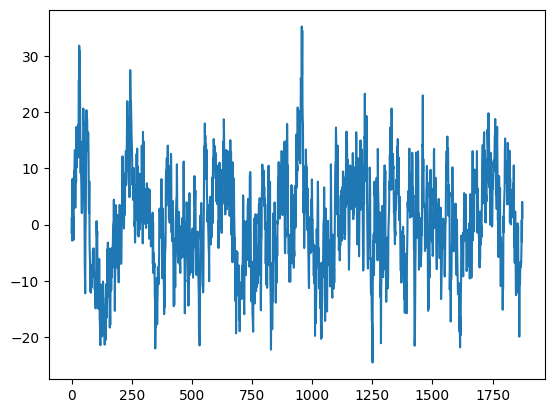

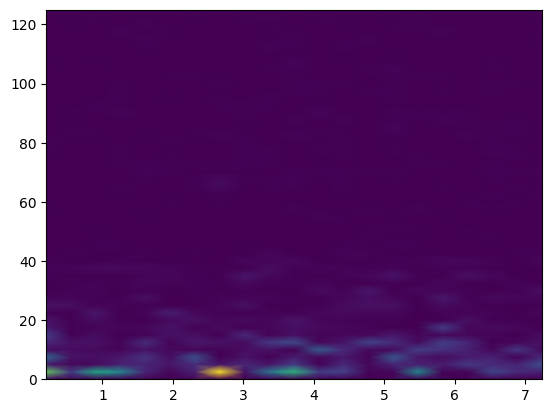

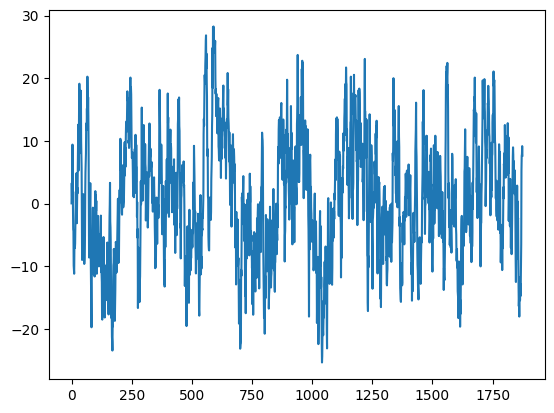

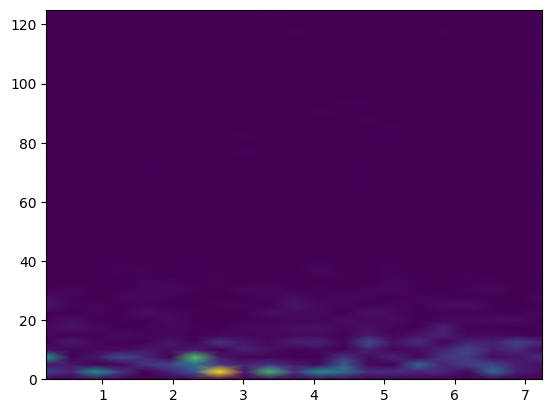

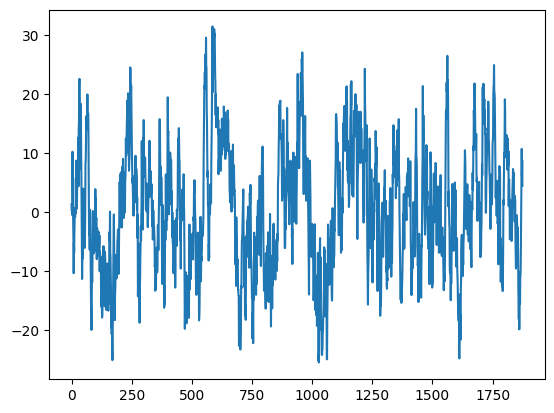

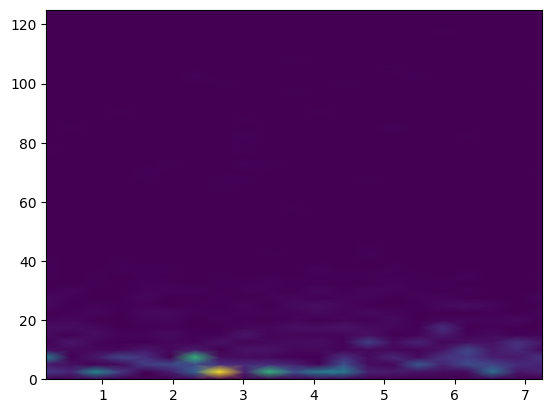

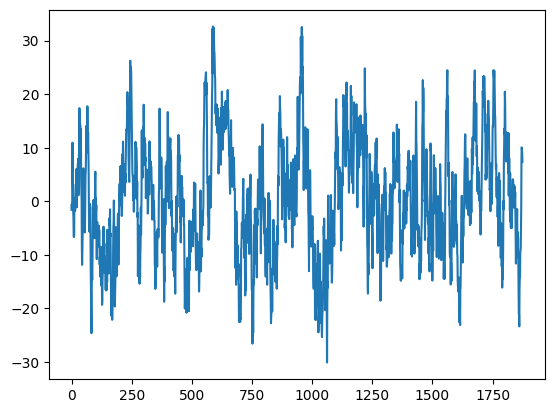

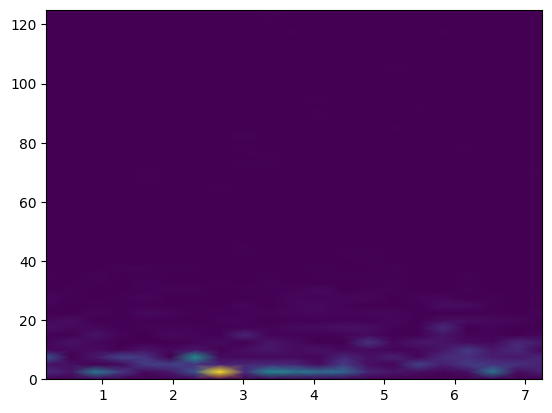

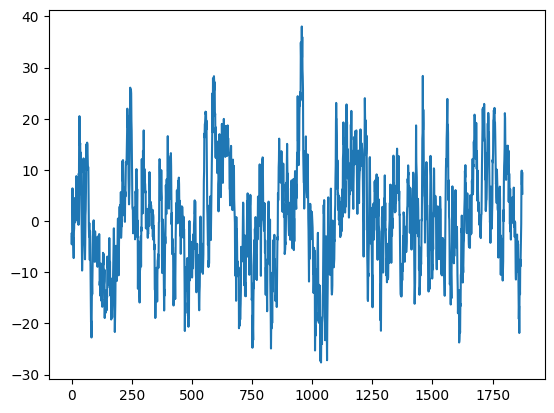

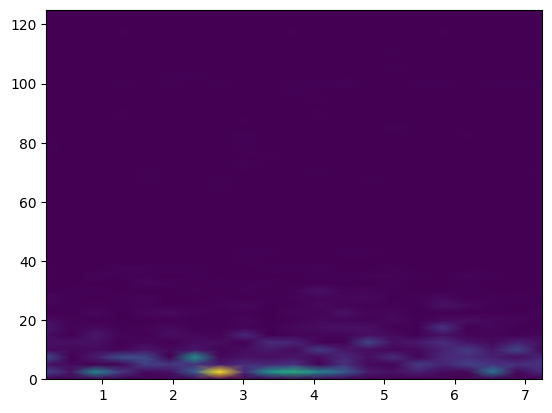

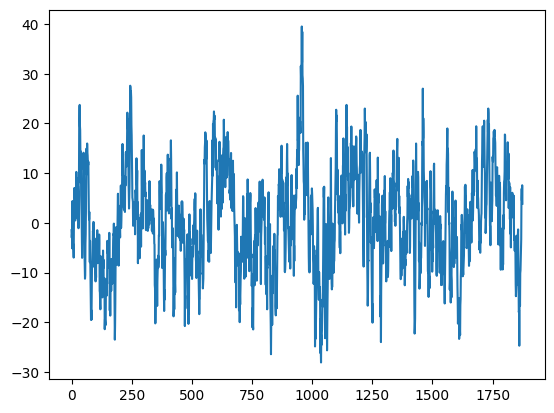

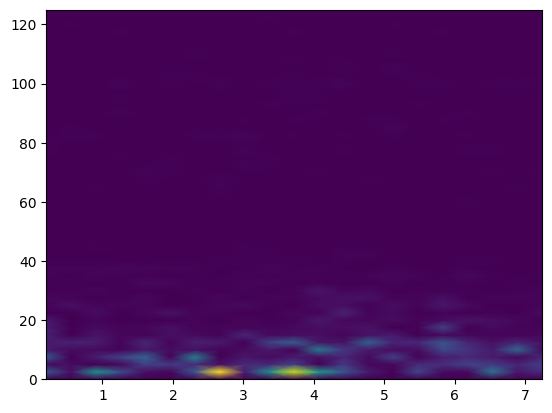

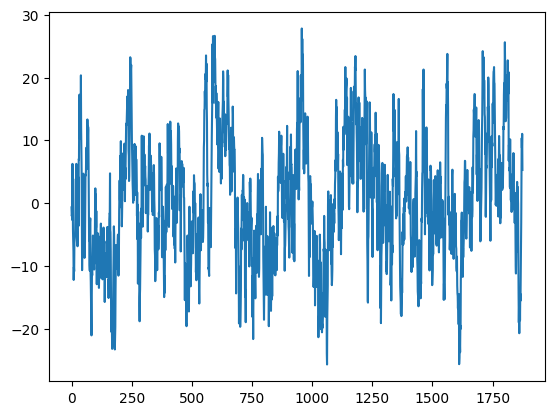

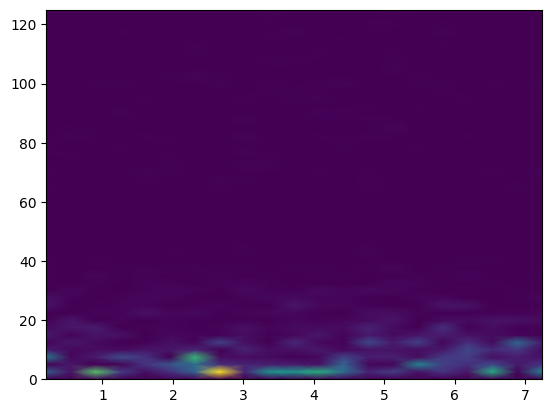

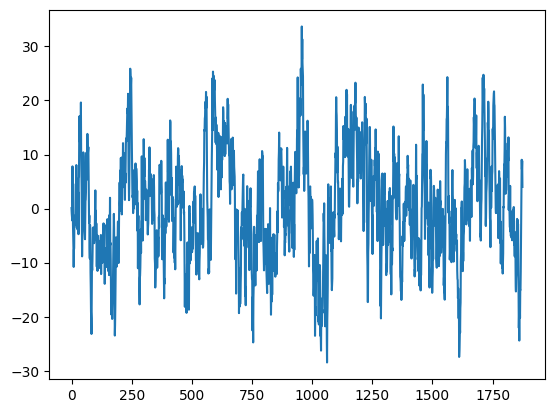

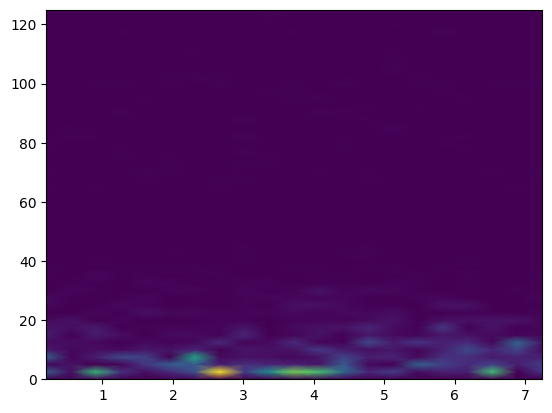

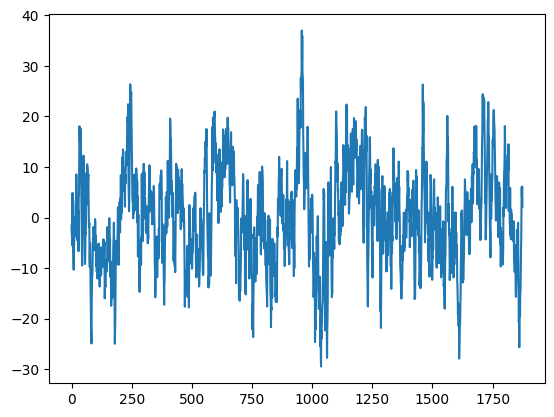

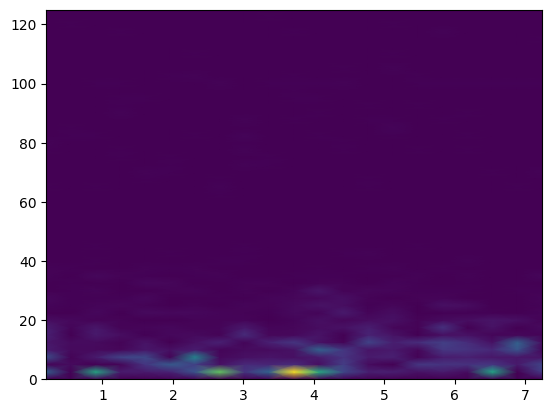

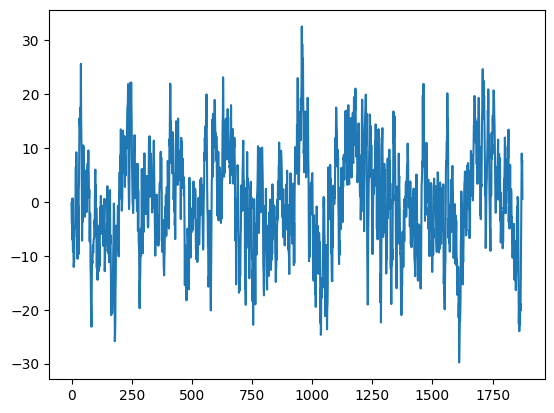

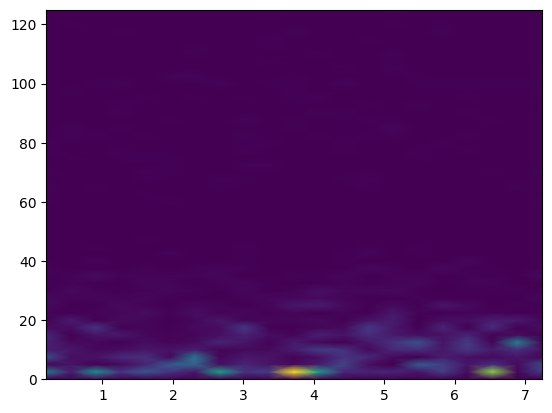

In [18]:
import scipy.signal as signal
import matplotlib.pyplot as plt

x = train_x[0]

for i in range(x.shape[0]):
    plt.plot(x[i])
    plt.show()

    f, t, Sxx = signal.spectrogram(x[i], fs=250, nperseg=100)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.show()